In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')
from collections import Counter

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#Reading the dataset into a dataframe
df = pd.read_csv('/content/drive/MyDrive/ML/ratings_Electronics.csv', header=None)

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

df = df.drop('timestamp', axis=1)

## Exploratory Data Analysis

In [7]:
#printing the dataset
df.head(10)


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
5,A1QGNMC6O1VW39,0511189877,5.0
6,A3J3BRHTDRFJ2G,0511189877,2.0
7,A2TY0BTJOTENPG,0511189877,5.0
8,A34ATBPOK6HCHY,0511189877,5.0
9,A89DO69P0XZ27,0511189877,5.0


In [8]:
#Analyzing the number of rows and columns in the dataset
rows, columns = df.shape
print("Number of rows in the dataset", rows)
print("Number of columns in the dataset ", columns)

Number of rows in the dataset 7824482
Number of columns in the dataset  3


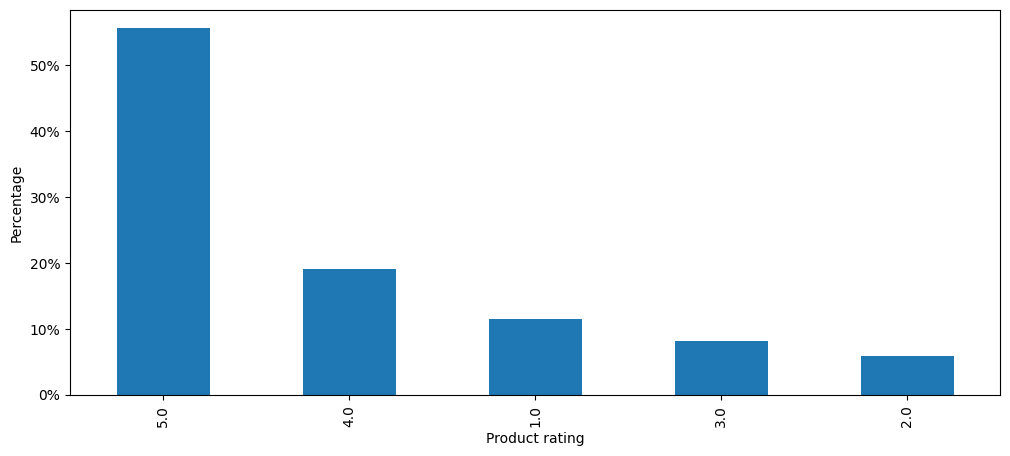

In [9]:
#plot the rating column

# Function to convert y-axis labels to percentages
def to_percent(y, position):
    return f'{y * 100:.0f}%'

plt.figure(figsize=(12, 5))
df['rating'].value_counts(1).plot(kind='bar')
plt.xlabel('Product rating')
plt.ylabel('Percentage')

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()


In [10]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]
df_final.head(20)
print('Total no of rows', len(df_final))
print('Total number of unique users ', df_final['user_id'].nunique())
print('Total number of unique products ', df_final['prod_id'].nunique())

Total no of rows 125871
Total number of unique users  1540
Total number of unique products  48190


In [11]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = Counter(users)



In [12]:
#Filter the users who has given atleast 50 ratings
ratings_cutoff = 50

remove_users = [user for user, num_ratings in ratings_count.items() if num_ratings < ratings_cutoff]

df = df.loc[~df.user_id.isin(remove_users)]


In [13]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = Counter(prods)

In [14]:
#Consider products having atleat 5 ratings
RATINGS_CUTOFF = 5

remove_prods = [prod for prod, num_ratings in ratings_count.items() if num_ratings < RATINGS_CUTOFF]

df_final = df.loc[~df.prod_id.isin(remove_prods)]


In [15]:
# Print a few rows of the imported dataset
df_final.head(10)

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0
1485,A19N3S7CBSU6O7,1400501466,5.0
2082,A2ZR3YTMEEIIZ4,1400532655,5.0
2150,A3CLWR1UUZT6TG,1400532655,5.0
2162,A5JLAU2ARJ0BO,1400532655,1.0
2228,A1P4XD7IORSEFN,1400532655,4.0


In [16]:
#Number of rows and columns in the dataset
df_final.shape

(65290, 3)

In [17]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [18]:
# Find number of missing values in each column
df_final.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

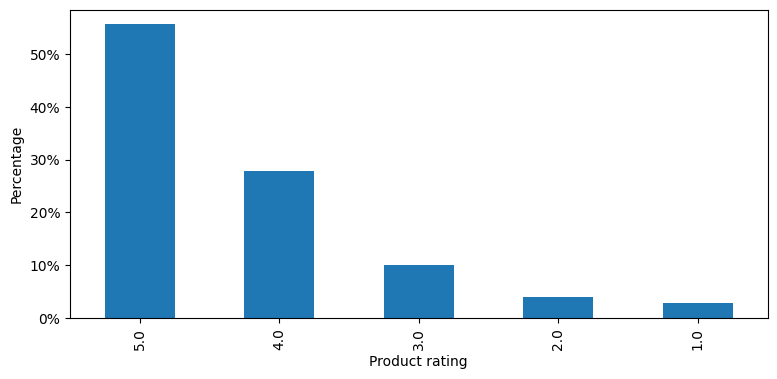

In [19]:
#plot the rating column

# Function to convert y-axis labels to percentages
def to_percent(y, position):
    return f'{y * 100:.0f}%'

plt.figure(figsize=(9,4))
df_final['rating'].value_counts(1).plot(kind='bar')
plt.xlabel('Product rating')
plt.ylabel('Percentage')

# Apply the percentage formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.show()

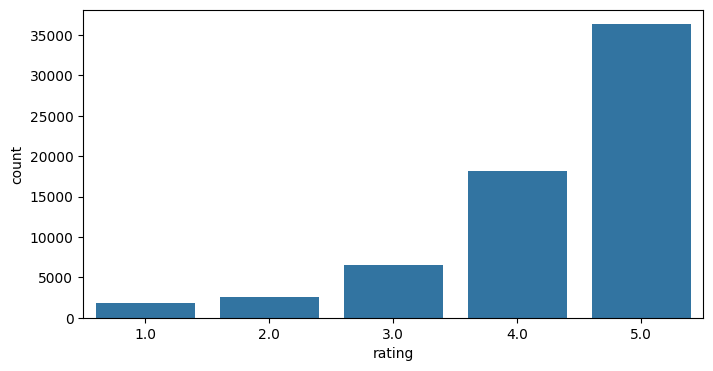

In [20]:
# Create the bar plot and provide observations
plt.figure(figsize=(8,4))
sns.countplot(x= 'rating',
            data = df_final)
# Show the plot
plt.show()

In [21]:
df_final['rating'].value_counts()

rating
5.0    36315
4.0    18127
3.0     6481
2.0     2515
1.0     1852
Name: count, dtype: int64

In [22]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]
df_final.head(20)
print('Total no of rows', len(df_final))
print('Total number of unique users ', df_final['user_id'].nunique())
print('Total number of unique products ', df_final['prod_id'].nunique())

Total no of rows 125871
Total number of unique users  1540
Total number of unique products  48190


Observations:

There are 1,540 unique users and 48190 unique products in the dataset.

## Model 1: Rank Based Recommendation System

In [23]:
# Get the counts of ratings for each user and retrieve the top 10 users
top10_users_ratings = df_final['user_id'].value_counts().head(10)

# Convert the Series to a DataFrame with column name 'counts'
df_top10_users_ratings = top10_users_ratings.to_frame('counts')

# Reset the index to make 'user_id' a column
df_top10_users_ratings.reset_index(inplace=True)

# Adjust the index to start from 1
df_top10_users_ratings.index = df_top10_users_ratings.index + 1

# Rename the columns
df_top10_users_ratings.columns = ['user_id', 'counts']

# Define a function to highlight the 'user_id' column in bold
def highlight_cols(x):
    # Make a copy of the DataFrame
    tmp = x.copy()
    # Apply the bold font-weight to the 'user_id' column
    tmp[:] = 'font-weight: bold'
    return tmp

# Apply the highlighting function to the DataFrame and display it
styled_df_top10_users_ratings = df_top10_users_ratings.style.apply(highlight_cols, subset='user_id', axis=1)
styled_df_top10_users_ratings

,user_id,counts
1,A5JLAU2ARJ0BO,520
2,ADLVFFE4VBT8,501
3,A3OXHLG6DIBRW8,498
4,A6FIAB28IS79,431
5,A680RUE1FDO8B,406
6,A1ODOGXEYECQQ8,380
7,A36K2N527TXXJN,314
8,A2AY4YUOX2N1BQ,311
9,AWPODHOB4GFWL,308
10,ARBKYIVNYWK3C,296


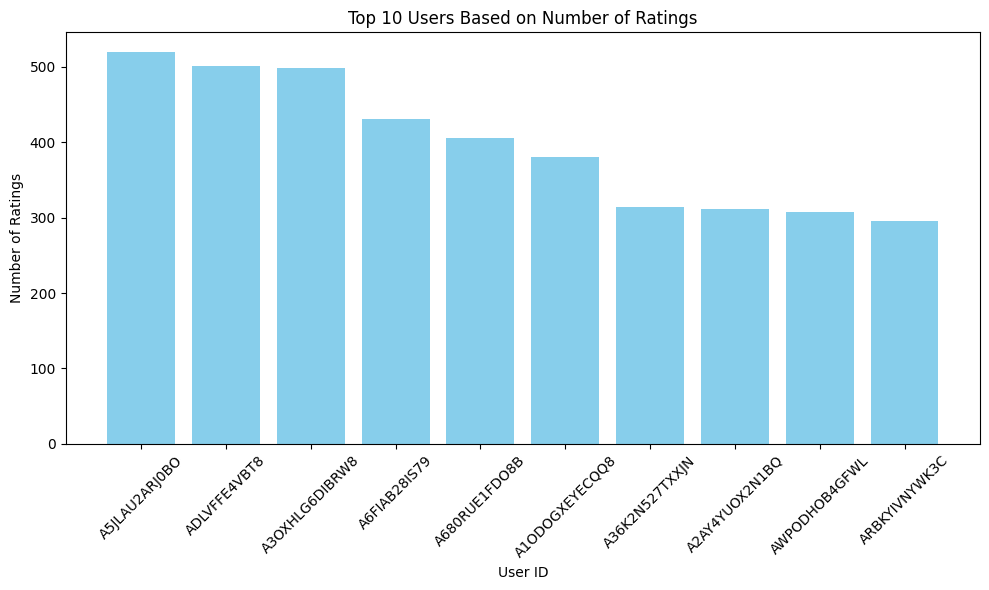

In [24]:
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df_top10_users_ratings['user_id'], df_top10_users_ratings['counts'], color='skyblue')

# Add labels and title
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Users Based on Number of Ratings')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [25]:
# Calculate average rating and count of ratings for each product, and create a DataFrame
final_rating = (df_final.groupby('prod_id')
                        .agg(avg_rating=('rating', 'mean'), rating_count=('rating', 'count'))
                        .sort_values(by='avg_rating', ascending=False))

# Display the first five records of the final_rating DataFrame
final_rating.head(5)

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [26]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
aggregate_count = df_final.groupby('prod_id').count()['rating']

# Create a dataframe with calculated average and count of ratings
df_averages_counts = pd.DataFrame({'avg_rating': average_rating, 'rating_count': aggregate_count})

# Sort the dataframe by average of ratings in the descending order
final_rating = df_averages_counts.sort_values(by=['avg_rating'],  ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head(5)

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [27]:
def top_n_products(data, n, min_interactions=100):
    return (data[data['rating_count'] >= min_interactions]  # Filter products with minimum interactions
            .sort_values(by='avg_rating', ascending=False)  # Sort by average rating
            .head(n))  # Retrieve the top n products

In [28]:
top_5_50_products = top_n_products(df_averages_counts, 10, 50)

display(top_5_50_products)

,avg_rating,rating_count
prod_id,,
B001TH7GUU,4.871795,78
B003ES5ZUU,4.864130,184
B0019EHU8G,4.855556,90
B006W8U2MU,4.824561,57
B000QUUFRW,4.809524,84
B000HPV3RW,4.803922,51
B001TH7GSW,4.803279,61
B000BQ7GW8,4.777778,54
B000N99BBC,4.772455,167


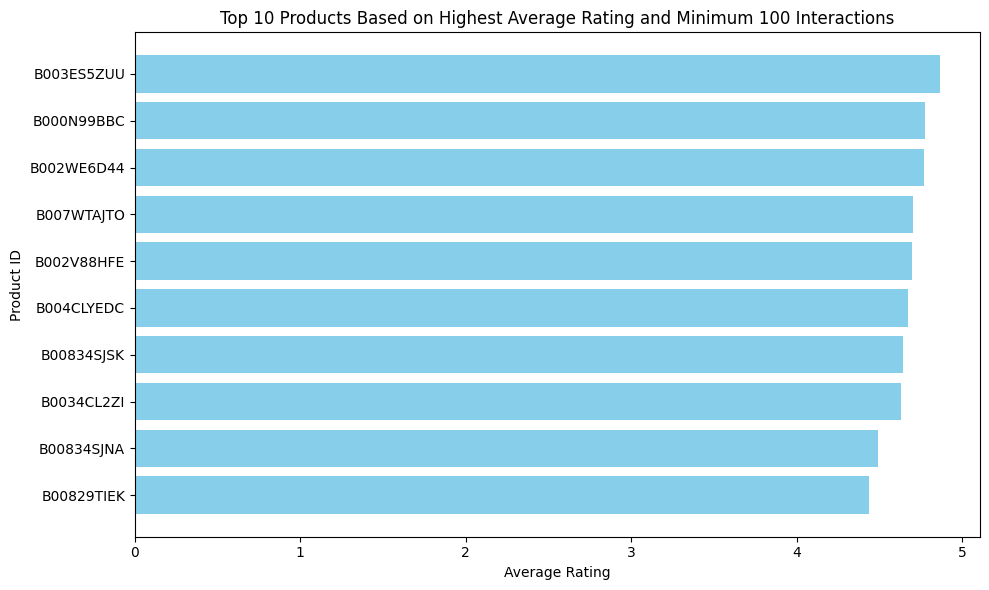

In [29]:
def plot_top_n_products(data, n, min_interactions=100):
    # Get top N products
    top_products = top_n_products(data, n, min_interactions)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_products.index, top_products['avg_rating'], color='skyblue')

    # Add labels and title
    plt.xlabel('Average Rating')
    plt.ylabel('Product ID')
    plt.title(f'Top {n} Products Based on Highest Average Rating and Minimum {min_interactions} Interactions')

    # Show plot
    plt.gca().invert_yaxis()  # Invert y-axis to display highest rating on top
    plt.tight_layout()
    plt.show()

# Example usage:
plot_top_n_products(final_rating, 10)

# Model 2: User based Collaborative Filtering Recommendation System

## similarity-based recommendation systems

In [30]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357223 sha256=b4c30dcdc3d67dba402591f64245098f986fe02025b7ebe6638c42bcb9488178
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [31]:
# To compute the accuracy of models
from surprise import accuracy
# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# Class for loading datasets
from surprise.dataset import Dataset
# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV
# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split
# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic
# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
# for implementing K-Fold cross-validation
from surprise.model_selection import KFold
# For implementing clustering-based recommendation system
from surprise import CoClustering
from collections import defaultdict
from surprise import accuracy
import math
from sklearn.decomposition import PCA

In [32]:
#Function to calculate Root Mean Squared Error
def calculate_rmse(predictions):
    mse = sum((pred.r_ui - pred.est) ** 2 for pred in predictions) / len(predictions)
    rmse = math.sqrt(mse)
    return round(rmse,4)

In [33]:
def precision_recall_at_k(model,k=30, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0


    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    F1_score = round((2*precision*recall)/(precision+recall), 3)
    RMSE = calculate_rmse(predictions)
    print('Precision: ', precision) # Command to print the overall precision
    print('Recall: ', recall) # Command to print the overall recall
    print('F_1 score: ', F1_score) # Formula to compute the F-1 score
    print('RMSE: ',RMSE)
    return RMSE, recall, F1_score, precision

In [34]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))
# Loading the dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.20, random_state=1)

In [35]:
# Declaring the similarity options.
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items.
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset, and predict ratings for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f1-score@k
RMSE, recall, F1_score, precision = precision_recall_at_k(sim_user_user)

Precision:  0.83
Recall:  0.935
F_1 score:  0.879
RMSE:  1.1114


In [36]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.80   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.8, details={'actual_k': 5, 'was_impossible': False})

Observations:

The predicted rating for this user and this product is 3.80, while the actual rating is 5.

In [37]:
# Find unique user_id where prod_id is not equal to "1400501466" i.e. list of users not interacted with producr id "1400501466"
not_seen = df_final[df_final.prod_id != "1400501466"]

not_seen

,user_id,prod_id,rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0
...,...,...,...
7824426,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824427,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0
7824436,A3AYSYSLHU26U9,B00LI4ZZO8,4.0
7824438,A2NYK9KWFMJV4Y,B00LI4ZZO8,5.0


In [38]:
#user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466" as this userId is a part of the above list.
'A34BZM6S9L7QI4' in not_seen['user_id'].unique()

True

In [39]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 2.00   {'actual_k': 2, 'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=1.99689485039987, details={'actual_k': 2, 'was_impossible': False})

Observations:

### The predicted rating for this user-item pair is 2 based on this user-user similarity model.

To enhance the performance of our similarity-based recommendation system, we'll fine-tune the hyperparameters of the KNNBasic algorithm. Here's an overview of some key hyperparameters:

k (int): This parameter specifies the maximum number of neighbors considered for aggregation during the recommendation process. The default value is set to 40.

min_k (int): This parameter sets the minimum number of neighbors required for aggregation. If there aren't enough neighbors available, the prediction defaults to the global mean of all ratings. By default, it's set to 1.

sim_options (dict): This is a dictionary containing options for the similarity measure used in the algorithm. Surprise offers four similarity measures:

cosine: Computes the cosine similarity between items/users.
msd (mean squared difference): Computes the similarity based on the mean squared difference between ratings.
Pearson: Calculates the Pearson correlation coefficient between items/users.
Pearson baseline: Similar to Pearson, but it subtracts the baseline similarity to address baseline drift.
During hyperparameter tuning, we'll experiment with different values for these parameters to optimize the performance of our recommendation system.

In [40]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'k': [20,30,40,50],  # Number of neighbors
    'min_k': [1,2,3,4,5],  # Minimum number of neighbors for aggregation
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson', 'pearson_baseline'],  # Similarity measure options
        'user_based': [True],  # Use user-based recommendation
        'min_support': [2, 4,6,8]  # Minimum number of common items for computing similarity
    }
}

# Initialize GridSearchCV with the KNNBasic algorithm, RMSE as the evaluation metric, and 3-fold cross-validation
gs = GridSearchCV(algo_class=KNNBasic, param_grid=param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fit the data to perform hyperparameter tuning
gs.fit(data)

# Get the best RMSE score
best_rmse_score = gs.best_score['rmse']

# Get the combination of parameters that gave the best RMSE score
best_params = gs.best_params['rmse']

# Print the results
print("Best RMSE score:", best_rmse_score)
print("Best parameters:", best_params)

Best RMSE score: 1.0569446452870246
Best parameters: {'k': 30, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


In [41]:
#building the final model by using tuned values of the hyperparameters, which we received by using grid search cross-validation.
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True, 'min_support': 2}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=4, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f1-score@k
RMSE, recall, F1_score, precision = precision_recall_at_k(sim_user_user_optimized)


Precision:  0.823
Recall:  0.973
F_1 score:  0.892
RMSE:  1.0534


Precision:  0.83
Recall:  0.935
F_1 score:  0.879
RMSE:  1.1114
Precision:  0.823
Recall:  0.973
F_1 score:  0.892
RMSE:  1.0534


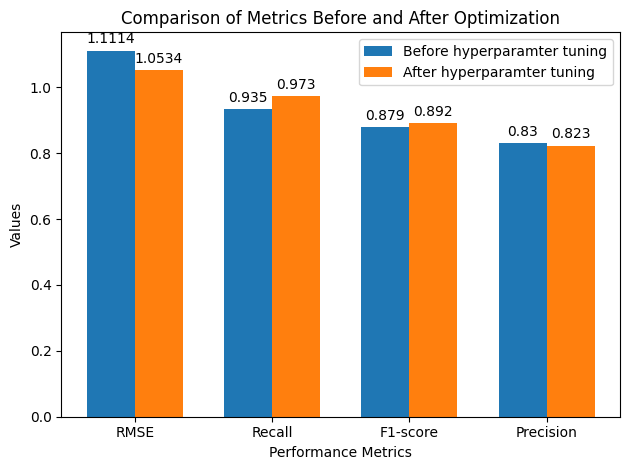

In [42]:
# Let us compute precision@k, recall@k, and f1-score@k
RMSE_1, recall_1, F1_score_1, precision_1 = precision_recall_at_k(sim_user_user)
# Let us compute precision@k, recall@k, and f1-score@k
RMSE_2, recall_2, F1_score_2, precision_2 = precision_recall_at_k(sim_user_user_optimized)

# Data to plot
metrics = ['RMSE', 'Recall', 'F1-score', 'Precision']
before_values = [RMSE_1, recall_1, F1_score_1, precision_1]
after_values = [RMSE_2, recall_2, F1_score_2, precision_2]

x = range(len(metrics))  # the label locations

fig, ax = plt.subplots()
width = 0.35  # the width of the bars

# Plotting the bars
rects1 = ax.bar(x, before_values, width, label='Before hyperparamter tuning')
rects2 = ax.bar([i + width for i in x], after_values, width, label='After hyperparamter tuning')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics Before and After Optimization')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(metrics)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()

plt.show()

Observation:
As we can visualize in the above plotting, performance of the model considerably increased by decreasing RMSE, improving Recall, F1-score, Precision

In [43]:
# Predicting rating for a sample user with an interacted product
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.260566457456106, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [44]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466" i.e predicting rating for a sample user with a non-interacted product
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.260566457456106, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observations:

In both cases the model indicates insufficient neighbors, and defaults to the global mean which is ~4.26.

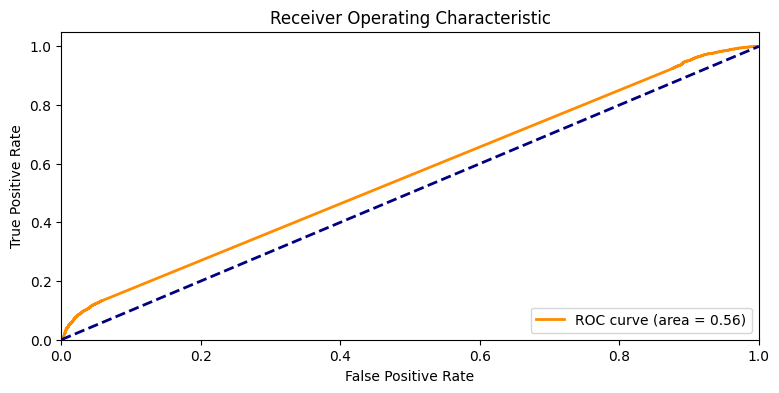

In [45]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, testset):
    predictions = model.test(testset)
    y_true = [int(true_r >= 3.5) for (_, _, true_r, _, _) in predictions]
    y_scores = [est for (_, _, _, est, _) in predictions]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(9, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(sim_user_user_optimized, testset)


## Implementing the recommendation algorithm based on optimized KNNBasic model

We're creating a function that takes a rating dataset, a user ID, the number of products to recommend, and a collaborative filtering algorithm as input. This function will provide a set of top_n recommended items for the specified user_id, leveraging the provided algorithm to predict ratings.

In [46]:
def get_recommendations(data, user_id, top_n, algo):
    # Create an empty list to store the recommended product IDs along with their predicted ratings
    recommendations = []

    # Create a user-item interactions matrix
    user_item_interactions_matrix = data.pivot(index='user_id', columns='prod_id', values='rating')

    # Extract product IDs that the user has not interacted with yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Iterate through each non-interacted product
    for item_id in non_interacted_products:
        # Predict the rating for the user-item pair
        predicted_rating = algo.predict(user_id, item_id).est

        # Append the product ID along with its predicted rating to the recommendations list
        recommendations.append((item_id, predicted_rating))

    # Sort the recommendations based on the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Return the top n recommendations with the highest predicted ratings
    return recommendations[:top_n]


In [47]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
user_id = 'A3LDPF5FMB782Z'
recommended_products = get_recommendations(df_final, user_id, 10, sim_user_user)
recommended_products

[('1400599997', 5),
 ('787988002X', 5),
 ('B000001OM4', 5),
 ('B000001OM5', 5),
 ('B000001OMI', 5),
 ('B00000DM9M', 5),
 ('B00000J08C', 5),
 ('B00000J1EQ', 5),
 ('B00000J1SC', 5),
 ('B00000J1UQ', 5)]

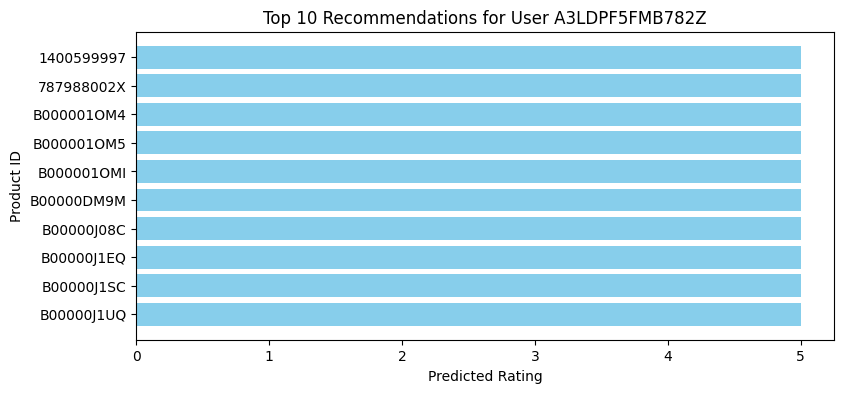

In [48]:
# Extract product IDs and their predicted ratings
prod_ids, predicted_ratings = zip(*recommended_products)

# Plotting the recommendations
plt.figure(figsize=(9, 4))
plt.barh(prod_ids, predicted_ratings, color='skyblue')
plt.xlabel('Predicted Rating')
plt.ylabel('Product ID')
plt.title(f'Top {len(recommended_products)} Recommendations for User {user_id}')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rating on top
plt.show()

## Model 3: Model-Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a personalized recommendation system that relies solely on a user's past behavior to generate recommendations, without needing any additional information. It utilizes latent features to determine recommendations tailored to each user.

In [49]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
RMSE, recall, F1_score, precision = precision_recall_at_k(svd)

Precision:  0.818
Recall:  0.939
F_1 score:  0.874
RMSE:  0.9862


Observations:

Performance of the model is good across all metrics. In particular the F_1 score is more elevated than with previous baseline models, and the RMSE is lower.

In [50]:
# Predicting rating for a sample user with an interacted product
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.19   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1877078792216444, details={'was_impossible': False})

Improving Matrix Factorization based recommendation system by tuning its hyperparameters¶
Below we will be tuning only three hyperparameters:

n_epochs: The number of iterations of the SGD algorithm.
lr_all: The learning rate for all parameters.
reg_all: The regularization term for all parameters.

In [51]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_epochs': [10, 20, 30],  # Number of epochs (iterations over the training data)
    'lr_all': [0.001, 0.005, 0.01],  # Learning rate for all parameters
    'reg_all': [0.02, 0.1, 0.2, 0.5],  # Regularization term for all parameters
}

# Initialize GridSearchCV with the SVD algorithm
# - measures=['rmse']: Specify RMSE as the evaluation metric
# - cv=3: Use 3-fold cross-validation
# - n_jobs=-1: Use all available CPU cores for parallel processing
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data to perform hyperparameter tuning
gs.fit(data)

# Retrieve the best RMSE score from the grid search
best_rmse_score = gs.best_score['rmse']

# Retrieve the combination of hyperparameters that gave the best RMSE score
best_params = gs.best_params['rmse']

# Print the results
print("Best RMSE score:", best_rmse_score)
print("Best parameters:", best_params)


Best RMSE score: 0.9810904523658396
Best parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


In [52]:
# Build the optimized SVD model using the best hyperparameters found during the search
svd_algo_optimized = SVD(n_epochs=30,  # Number of epochs (iterations over the training data)
                         lr_all=0.005,  # Learning rate for all parameters
                         reg_all=0.2,  # Regularization term for all parameters
                         random_state=1)  # Set random state for reproducibility

# Train the algorithm on the training set
svd_algo_optimized.fit(trainset)

# Compute precision@k, recall@k, F1-Score, and RMSE using the defined function
RMSE, recall, F1_score, precision = precision_recall_at_k(svd_algo_optimized)


Precision:  0.82
Recall:  0.95
F_1 score:  0.88
RMSE:  0.9799


Precision:  0.818
Recall:  0.939
F_1 score:  0.874
RMSE:  0.9862
Precision:  0.82
Recall:  0.95
F_1 score:  0.88
RMSE:  0.9799


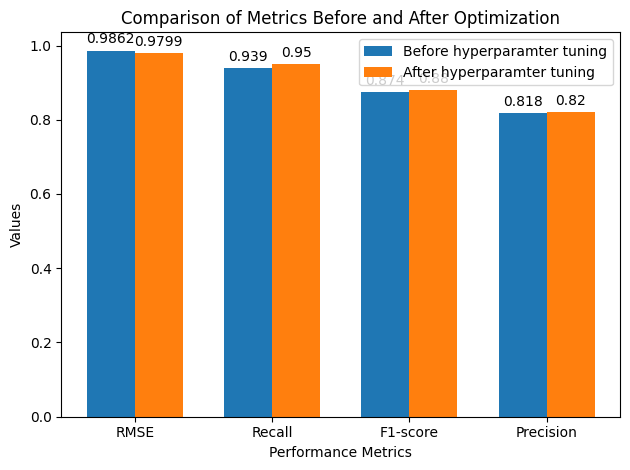

In [53]:
# Let us compute precision@k, recall@k, and f1-score@k
RMSE_1, recall_1, F1_score_1, precision_1 = precision_recall_at_k(svd)
# Let us compute precision@k, recall@k, and f1-score@k
RMSE_2, recall_2, F1_score_2, precision_2 = precision_recall_at_k(svd_algo_optimized)

# Data to plot
metrics = ['RMSE', 'Recall', 'F1-score', 'Precision']
before_values = [RMSE_1, recall_1, F1_score_1, precision_1]
after_values = [RMSE_2, recall_2, F1_score_2, precision_2]

x = range(len(metrics))  # the label locations

fig, ax = plt.subplots()
width = 0.35  # the width of the bars

# Plotting the bars
rects1 = ax.bar(x, before_values, width, label='Before hyperparamter tuning')
rects2 = ax.bar([i + width for i in x], after_values, width, label='After hyperparamter tuning')

# Adding some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Performance Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics Before and After Optimization')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(metrics)
ax.legend()

# Function to add labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()

plt.show()

Observation:
As we can visualize in the above plotting, performance of the model considerably increased by decreasing RMSE, improving Recall, F1-score, Precision

In [54]:
# predicting rating for the interacted product using SVD model
svd_algo_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.09   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.091713769175347, details={'was_impossible': False})

In [55]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_algo_optimized.predict('A34BZM6S9L7QI4', '1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.36   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.364898509099845, details={'was_impossible': False})

In [56]:
raw_data = data.raw_ratings
df = pd.DataFrame(raw_data, columns=['user_id', 'prod_id', 'rating', 'timestamp'])

# Drop the timestamp column as it is not needed
df = df.drop('timestamp', axis=1)

In [57]:
# Function to get recommendations
def get_recommendations_for_user(df, user_id, top_n, algo):
    # Creating an empty list to store the recommended product IDs along with their predicted ratings
    recommendations = []

    # Creating a user-item interactions matrix
    user_item_interactions_matrix = df.pivot(index='user_id', columns='prod_id', values='rating')

    # Extracting product IDs that the user has not interacted with yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Iterating through each non-interacted product
    for item_id in non_interacted_products:
        # Predicting the rating for the user-item pair
        predicted_rating = algo.predict(user_id, item_id).est

        # Appending the product ID along with its predicted rating to the recommendations list
        recommendations.append((item_id, predicted_rating))

    # Sorting the recommendations based on the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Returning the top n recommendations with the highest predicted ratings
    return recommendations[:top_n]


In [58]:
user_id = 'A3LDPF5FMB782Z'
recommended_products = get_recommendations_for_user(df, 'A3LDPF5FMB782Z', 10, svd)
recommended_products

[('B0074FGLUM', 4.973611620812693),
 ('B008ALA6DW', 4.906813504563049),
 ('B00BW6KCTU', 4.886747746996703),
 ('B008EQYRRY', 4.881113864366822),
 ('B001TH7T2U', 4.849566805698556),
 ('B00081A2KY', 4.848737993892506),
 ('B003CJTQJC', 4.832262944310637),
 ('B00IVFDZBC', 4.824943902259249),
 ('B005ES0YYA', 4.815130404762683),
 ('B001IEZX3G', 4.795691861874547)]

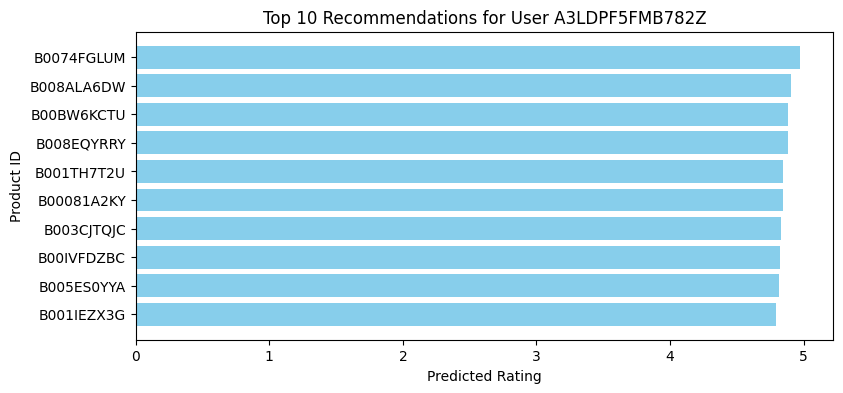

In [59]:
# Extract product IDs and their predicted ratings
prod_ids, predicted_ratings = zip(*recommended_products)

# Plotting the recommendations
plt.figure(figsize=(9, 4))
plt.barh(prod_ids, predicted_ratings, color='skyblue')
plt.xlabel('Predicted Rating')
plt.ylabel('Product ID')
plt.title(f'Top {len(recommended_products)} Recommendations for User {user_id}')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest rating on top
plt.show()
